### Imports

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()
    
sys.path.append(os.path.dirname(root))

# Import dispatcher
from SynAS.SynAS import dispatcher

### Instantiate

In [2]:
seed = 20 # set seed
length = 12*60*60 # 12 hour

dispatch = dispatcher(length=length, seed=seed)

### Dummy Third-Party Simulator (Battery)

In [3]:
class battery(object):
    def __init__(self, capacity=150, step=4, soc_init=0.5):
        '''
        Simple battery model.
        
        Inputs
        ------
        capacity (float): Capacity, in MWh. (default = 100)
        step (int): Stepsize, in seconds. (default = 4)
        soc_init (float): Initial State of Charge. (default=0.5)
        '''
        self.capacity = capacity
        self.step = step
        self.soc = soc_init
        self.soe = self.capacity * self.soc
    def do_step(self, power):
        self.soe = self.soe + power / (60*60/self.step)
        self.soe = min(self.soe, self.capacity)
        self.soe = max(self.soe, 0)
        self.soc = self.soe / self.capacity
        return self.soc

### Iterate Simulation

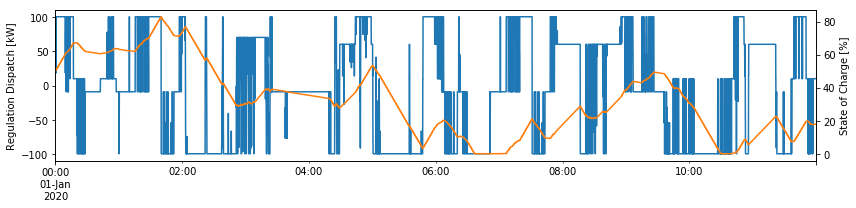

In [4]:
res = pd.DataFrame()
resource = battery()
for ts in range(0, dispatch.length, dispatch.step):
    
    # Next step from dispatcher
    dp = dispatch.do_step()
    
    # Feed to third-party simulator (battery)
    soc = resource.do_step(dp[1])
    
    # Store result
    res.loc[dp[0], 'Dispatch [kW]'] = dp[1]
    res.loc[dp[0], 'State of Charge [%]'] = soc * 1e2
    
# Prepare results and make plot
res.index = [pd.to_datetime('2020-01-01')+pd.DateOffset(seconds=ix) for ix in res.index]
res = res.resample('1S').ffill()
ax = res.plot(secondary_y=['State of Charge [%]'], legend=False, figsize=(12,3))
ax.set_ylabel('Regulation Dispatch [kW]')
ax.right_ax.set_ylabel('State of Charge [%]')
plt.tight_layout()
plt.show()